<a href="https://colab.research.google.com/github/JesseTNRoberts/AAAI-paper-2024/blob/main/pop_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Assuming your CSV file is named "data.csv"
from google.colab import drive
drive.mount('/content/drive')

loc = "/content/drive/MyDrive/Data/"

misra_data_bert = pd.read_csv(loc+'rosch1975_alternate/bert-base-uncased.csv')
pop_data_bert = pd.read_csv(loc+'rosch1975_alternate_popLM/bert-base-uncased_5.csv')
bert_freq = pd.read_csv(loc+'bert_word_frequencies.csv')

Mounted at /content/drive


In [3]:
!pip install nbformat --upgrade
!pip install seaborn --upgrade
!pip install researchpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.6/77.6 kB 495.0 kB/s eta 0:00:00
  Attempting uninstall: nbformat
    Found existing installation: nbformat 5.9.1
    Uninstalling nbformat-5.9.1:
      Successfully uninstalled nbformat-5.9.1


In [250]:
from pandas._libs.lib import is_timedelta_or_timedelta64_array
import pandas as pd
import plotly.graph_objects as go
import researchpy as rp
import numpy as np
import ast
import seaborn as sns
import matplotlib.pyplot as plt

models = ['bert-base-uncased', 'bert-large-uncased', 'distilbert-base-uncased', 'distilgpt2',
          'gpt2-medium', 'gpt2', 'openai-gpt', 'roberta-base', 'roberta-large']

# 3 through 6 are CLMs
model = models[-1]
stimulus = 'bird.'

misra_data_bert = pd.read_csv(loc+'rosch1975_alternate/'+model+".csv")
pop_data_bert_50 = pd.read_csv(loc+'rosch1975_alternate_popLM_50/'+model+".csv")
rosch_ratings = pd.read_csv(loc+'rosch1975_ratings.csv')


mergedDF_50 = pop_data_bert_50.copy()
mergedDF_50['misra score (sum, mean, [list])'] = misra_data_bert['score (sum, mean, [list)'].apply(ast.literal_eval)
mergedDF_50 = pd.merge(mergedDF_50, rosch_ratings, on=['item', 'category'], how='left')

mergedDF_50['score (sum, mean, [list)'] = mergedDF_50['score (sum, mean, [list)'].apply(ast.literal_eval)
mergedDF_50.rename(columns={'score (sum, mean, [list)': 'popLM score (sum, mean, [list])'}, inplace=True)

# for sum
#select_reduction = 0
# for mean
select_reduction = 1

mergedDF_50['population data'] = mergedDF_50.apply(
    lambda row: [2**t[select_reduction] for t in row['popLM score (sum, mean, [list])']],
    axis=1)
mergedDF_50['misra_avg'] = mergedDF_50.apply(
    lambda row: 2**row['misra score (sum, mean, [list])'][select_reduction],
    axis=1)


mergedDF_50['misra_avg'] = mergedDF_50['misra_avg'].astype('float')
mergedDF_50['rating'] = mergedDF_50['rating'].astype('float')
mergedDF_50['rank'] = mergedDF_50['rank'].astype('float')




if model in models[0:2]:
  this = bert_freq[bert_freq['freq']>200][['index','freq']]
  # This is really only applicable for Bert type models
  def quick(x):
    try:
      return this.loc[x['item']]['freq']
    except:
      return 0

  this.set_index("index", inplace = True)
  mergedDF_50['term freqs'] = mergedDF_50.apply(
      lambda x : quick(x),
      axis=1
  )

boxplots = []
misra_avg_markers = []

df = mergedDF_50.copy()

# Iterate through each row of the DataFrame and create a boxplot for each row
for index, row in df.iterrows():
    if(row['stimulus'] == stimulus):
        item = row['item']
        population_data = row['population data']
        boxplot = go.Box(y=population_data,
                         name=item,
                         boxmean='sd')
        boxplots.append(boxplot)
        misra_avg = row['misra_avg']

        misra_avg_marker = go.Scatter(x=[item], y=[misra_avg], mode='markers',
                                  name='Misra Avg', marker=dict(color='red', symbol='star'))
        misra_avg_markers.append(misra_avg_marker)

# Create the figure with all the boxplots
fig = go.Figure(data=boxplots + misra_avg_markers)

# Update the layout to provide a title and labels for the axes
fig.update_layout(
    title="Bird log distribution (misra shown as star)",
    xaxis_title="Preamble",
    yaxis_title="Population Data",
)

# Show the interactive plot in Jupyter Notebook
fig.show()



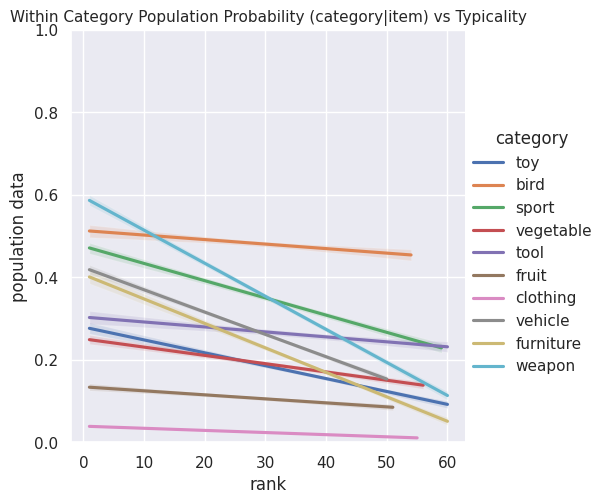

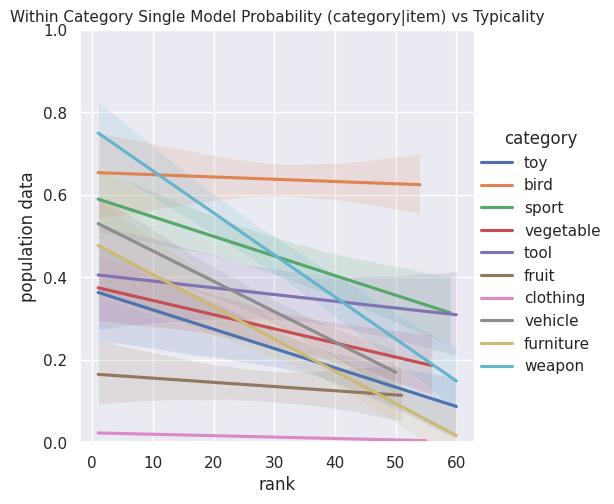

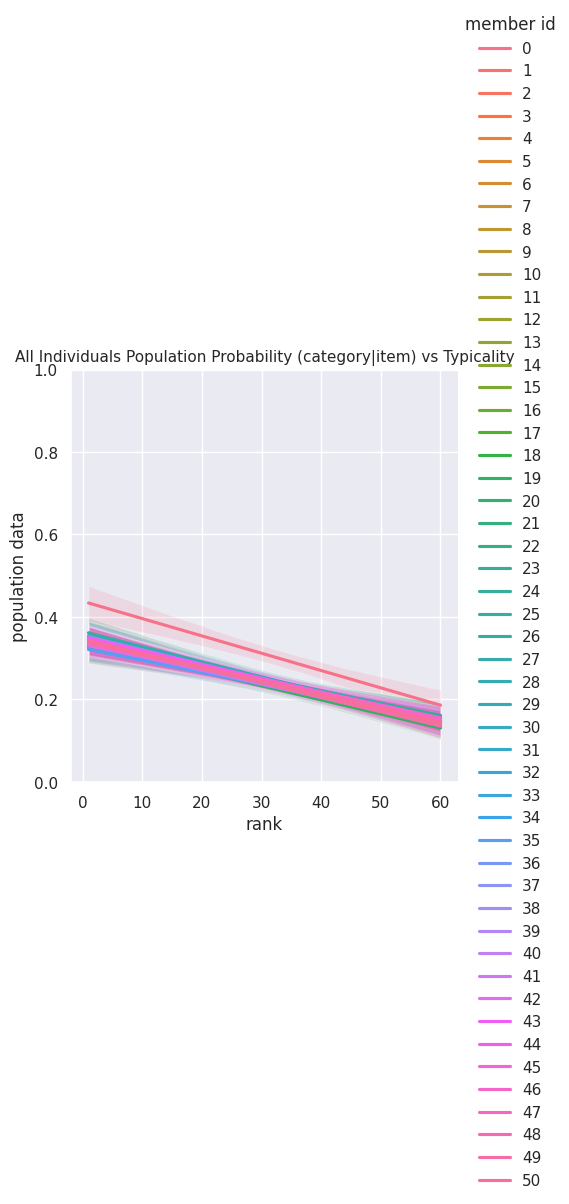

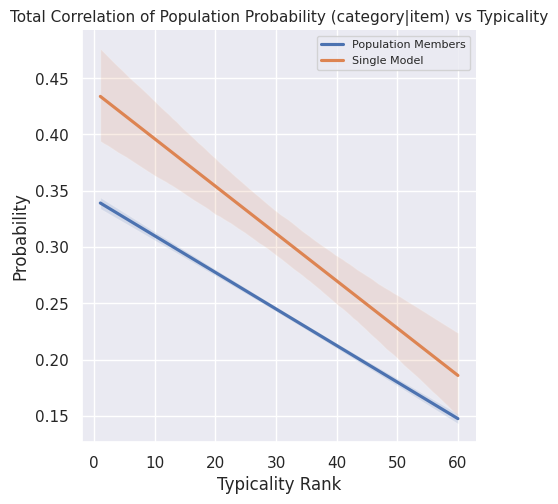

In [258]:
cols = ['population data', 'item', 'category', 'misra_avg', 'rating', 'rank']

# only applicable for bert
if model in models[0:2]:
  cols.append('term freqs')

df = mergedDF_50.copy()[cols]

df = df.explode('population data')
df['member id'] = df.groupby(['item', 'category']).cumcount()+1
df['population data'] = df['population data'].astype('float')

misra = df.copy().drop(columns=['population data', 'member id']).drop_duplicates()
misra['population data'] = misra['misra_avg']
misra = misra.drop(columns = 'misra_avg')
misra['member id'] = misra.apply(
    lambda row: 0,
    axis = 1
)
df = df.drop(columns='misra_avg')

# misra has member id = 0
df = pd.concat([df, misra])

df['Group'] = df.apply(
    lambda row: "Single Model" if row['member id'] == 0 else "Population Members",
    axis=1)



#sns.set(rc={'figure.figsize':(11.7,8.27)})
#fig1, ax = plt.subplots()
#sns.boxplot(x="rating", y="population data", data=df, ax=ax )

sns.set( rc = {'figure.figsize' : ( 40, 40 ),
               'axes.labelsize' : 12 })

sns.lmplot(x='rank', y="population data", data=df[df['member id']>0], scatter=False, hue ='category')
plt.ylim(0, 1.0)
plt.title( "Within Category Population Probability (category|item) vs Typicality" , size = 11 )
plt.show()

sns.lmplot(x="rank", y="population data", data=df[df['member id'] == 0], scatter=False, hue ='category')
plt.ylim(0, 1.0)
plt.title( "Within Category Single Model Probability (category|item) vs Typicality" , size = 11 )
plt.show()


sns.lmplot(x="rank", y="population data", data=df, scatter=False, hue ='member id')
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.ylim(0, 1.0)
plt.title( "All Individuals Population Probability (category|item) vs Typicality" , size = 11 )
plt.show()

ax = sns.lmplot(x="rank", y="population data", data=df, scatter=False, hue ='Group', legend=False)
sns.set(rc={'figure.figsize':(11.7,8.27)})
#plt.ylim(0, 1.0)
plt.title( "Total Correlation of Population Probability (category|item) vs Typicality" , size = 11 )
plt.legend(fontsize=8, title_fontsize=10)
ax.set(xlabel='Typicality Rank', ylabel='Probability')
plt.show()


--------------
                 population data        rating          rank    term freqs  \
population data         1.000000 -3.646303e-01 -2.776661e-01 -8.528984e-02   
rating                 -0.364630  1.000000e+00  9.301579e-01  1.010410e-02   
rank                   -0.277666  9.301579e-01  1.000000e+00 -1.420593e-02   
term freqs             -0.085290  1.010410e-02 -1.420593e-02  1.000000e+00   
member id              -0.000978 -8.196421e-16  7.896386e-17  5.446456e-16   
z score                 0.041456 -6.593563e-03 -3.820885e-03 -1.627565e-03   
normalized              0.258167  1.287989e-03  1.090439e-03  1.713155e-03   

                    member id   z score  normalized  
population data -9.784425e-04  0.041456    0.258167  
rating          -8.196421e-16 -0.006594    0.001288  
rank             7.896386e-17 -0.003821    0.001090  
term freqs       5.446456e-16 -0.001628    0.001713  
member id        1.000000e+00 -0.004361   -0.002105  
z score         -4.361367e-03  1.000

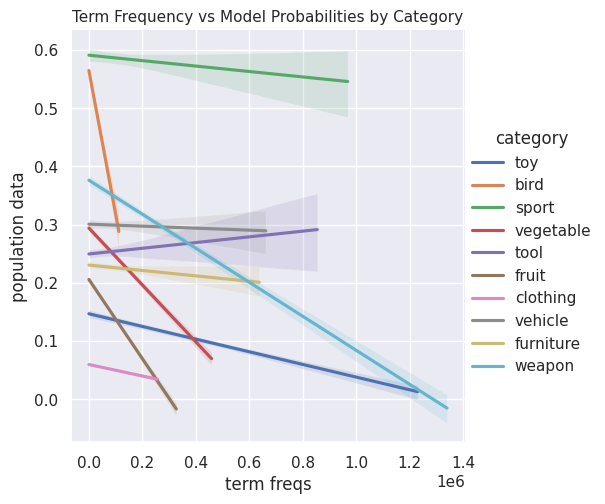

z score significance
  Pearson correlation test using list-wise deletion
0                   Total observations used = 28250
           rank z score
rank        1.0 -0.0038
z score -0.0038     1.0
           rank z score
rank     0.0000  0.5208
z score  0.5208  0.0000
Normalized data significance
  Pearson correlation test using list-wise deletion
0                   Total observations used = 28250
              rank normalized
rank           1.0     0.0011
normalized  0.0011        1.0
              rank normalized
rank        0.0000     0.8546
normalized  0.8546     0.0000
-------------
                 population data    rating      rank  term freqs  member id  \
population data         1.000000 -0.377960 -0.288183   -0.104675        NaN   
rating                 -0.377960  1.000000  0.930158    0.010104        NaN   
rank                   -0.288183  0.930158  1.000000   -0.014206        NaN   
term freqs             -0.104675  0.010104 -0.014206    1.000000        NaN   
member id

,population data,item,category,rating,rank,term freqs,member id,Group,z score,normalized
0,0.393573,doll,toy,1.41,1.0,27332.0,1,Population Members,0.174572,1.037470
0,0.425666,doll,toy,1.41,1.0,27332.0,2,Population Members,0.568717,1.122068
0,0.340374,doll,toy,1.41,1.0,27332.0,3,Population Members,0.478771,0.897238
0,0.377552,doll,toy,1.41,1.0,27332.0,4,Population Members,0.022187,0.995238
0,0.390351,doll,toy,1.41,1.0,27332.0,5,Population Members,0.135008,1.028978
...,...,...,...,...,...,...,...,...,...,...
564,0.160268,shoe,weapon,6.23,60.0,28927.0,46,Population Members,0.631158,1.235371
564,0.141573,shoe,weapon,6.23,60.0,28927.0,47,Population Members,0.244739,1.091268
564,0.157126,shoe,weapon,6.23,60.0,28927.0,48,Population Members,0.566213,1.211152
564,0.095168,shoe,weapon,6.23,60.0,28927.0,49,Population Members,0.714443,0.733570


In [16]:
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore

rosch_val = 'rank'
#rosch_val = 'rating'

corr_df = df.copy()

corr_df['z score'] = corr_df.groupby(['item','category'])['population data'].transform(zscore).apply(abs)

# Mean normalized
corr_df['normalized'] = corr_df.groupby(['item','category'])['population data'].transform(lambda x: x/np.mean(x))

corr_misra = corr_df[corr_df['member id']==0]
corr_df = corr_df[corr_df['member id']>0]


test = 'pearson'

print('--------------')
print(corr_df.corr(method=test))

print('prob significance')
i,r,p = rp.correlation.corr_case(corr_df[[rosch_val, 'population data']], method = test)
print(i)
print(r)
print(p)

if model in models[0:2]:
  print('prob significance vs term freq')
  i,r,p = rp.correlation.corr_case(corr_df[['term freqs', 'population data']], method = test)
  print(i)
  print(r)
  print(p)

  sns.lmplot(x='term freqs', y="population data", data=df, scatter=False, hue='category')
  plt.title( "Term Frequency vs Model Probabilities by Category" , size = 11 )
  plt.show()

print('z score significance')
i,r,p = rp.correlation.corr_case(corr_df[[rosch_val, 'z score']], method = test)
print(i)
print(r)
print(p)

print('Normalized data significance')
i,r,p = rp.correlation.corr_case(corr_df[[rosch_val, 'normalized']], method = test)
print(i)
print(r)
print(p)

print('-------------')
print(corr_misra.corr(method=test))

print('single model prob significance')
i,r,p = rp.correlation.corr_case(corr_misra[[rosch_val, 'population data']], method = test)
print(i)
print(r)
print(p)

corr_df

2 claims

1. single model studies don't permit confidence about relationships
  - the model may be an outlier as is the case in the bird category
  - the model may be biased as is the case in roberta large such that the overall line of best fit is inflated
  - Further, the line of best fit may have a large confidence interval such that describing the relationship is difficult.
  - The single model may itself be an outlier as is seen to be the case for roberta large
2. Since we need a large body of data to become confident, this may prevent comparison to psychological studies as pscyhological studies have multiple participants with limited questions
  - populations allow us to modify and run studies for similar comparison
  - as an example looking at the within category relationship is not possible for the single model study as the statistical significance is far too low for conclusions to be drawn.
  - In a population this is not an issue and we can look at the within category relationships with tight confidence bounds and high significance
  - The single roberta large model can't reason about the within categories well at all, but no conclusions can be drawn at all regarding the bird, tool, and fruit categories. This is reflected in the correlation and the lines of best fit for the single model. (the line of best fit may be positive sloped or negatively sloped, we can't say from the data, and the correlation is not significant)
  - The population gives insight here and shows that indeed the slopes are negative. So, even though the association is weak in these categories, it is present significantly.

bert-large-uncased
--------------
toy
                 population data        rating          rank    term freqs  \
population data         1.000000 -3.509654e-01 -3.924140e-01 -1.620724e-01   
rating                 -0.350965  1.000000e+00  9.697950e-01  1.139947e-01   
rank                   -0.392414  9.697950e-01  1.000000e+00  8.036516e-02   
term freqs             -0.162072  1.139947e-01  8.036516e-02  1.000000e+00   
member id              -0.002017  1.214294e-15  1.391999e-15 -5.918691e-18   
z score                 0.050172 -1.831419e-03 -1.961478e-03  2.070359e-03   
normalized              0.214211  1.488702e-03  2.089431e-03 -1.244973e-03   

                    member id   z score  normalized  
population data -2.017030e-03  0.050172    0.214211  
rating           1.214294e-15 -0.001831    0.001489  
rank             1.391999e-15 -0.001961    0.002089  
term freqs      -5.918691e-18  0.002070   -0.001245  
member id        1.000000e+00  0.002532    0.000663  
z score      

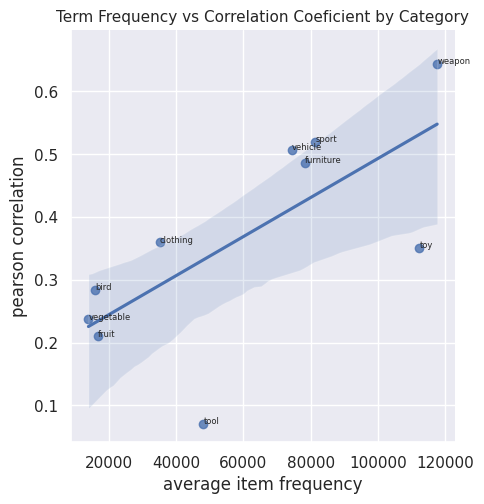

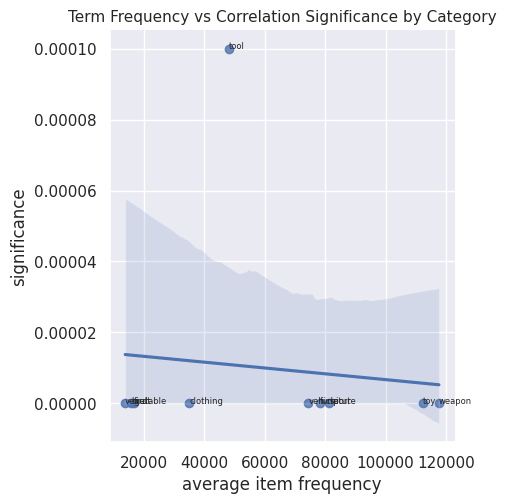

(  Pearson correlation test using list-wise deletion
0                      Total observations used = 10,                        average item frequency pearson correlation
average item frequency                    1.0              0.7012
pearson correlation                    0.7012                 1.0,                        average item frequency pearson correlation
average item frequency                 0.0000              0.0239
pearson correlation                    0.0239              0.0000)
(  Pearson correlation test using list-wise deletion
0                      Total observations used = 10,                        average item frequency significance
average item frequency                    1.0      -0.1016
significance                          -0.1016          1.0,                        average item frequency significance
average item frequency                 0.0000       0.7800
significance                           0.7800       0.0000)


In [32]:
#rosch_val = 'rank'
rosch_val = 'rating'


categories = ['toy', 'clothing', 'sport', 'bird', 'tool', 'vegetable', 'vehicle', 'weapon', 'fruit', 'furniture']

print(model)

corrs = []
sigs = []
cat_freqs = []

for category in categories:

  temp = corr_df.copy()[corr_df['category']==category]
  print('--------------')
  print(category)
  print(temp.corr(method=test))

  i,r,p = rp.correlation.corr_case(temp[[rosch_val, 'population data']], method = test)
  # print(i)
  # print(r)
  print(p)

  if model in models[0:2]:
    sigs.append(p[rosch_val][1])
    corrs.append(r[rosch_val][1])
    cat_freqs.append(np.mean(temp['term freqs']))

  temp = corr_misra.copy()[corr_misra['category']==category]
  #print('-------------')
  print(temp.corr(method=test))

  i,r,p = rp.correlation.corr_case(temp[[rosch_val, 'population data']], method = test)
  # print(i)
  # print(r)
  print(p)


# check to see if the correlation with in categories of the prob is correlated with term frequency or category frequency in training

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']),size=6)

if model in models[0:2]:
  df = pd.DataFrame(list(zip(categories, corrs, sigs, cat_freqs)),
                columns =['category', test+' correlation', 'significance', 'average item frequency'])

  # df = df[df['category']!='tool']
  # df = df[df['category']!='toy']

  # we multiply by negative 1 for display because the scale of the rank is inverted meaning the correlation sign is inverted
  df[test+' correlation'] = -1*df[test+' correlation']
  df['significance'] = df['significance'].astype('float')

  sns.lmplot(x='average item frequency', y=test+' correlation', data=df, scatter=True)
  plt.title( "Term Frequency vs Correlation Coeficient by Category" , size = 11 )
  label_point(df['average item frequency'], df[test+' correlation'], df['category'], plt.gca())
  plt.show()


  sns.lmplot(x='average item frequency', y="significance", data=df, scatter=True)
  plt.title( "Term Frequency vs Correlation Significance by Category", size = 11 )
  label_point(df['average item frequency'], df['significance'], df['category'], plt.gca())
  plt.show()


  # df = df[df['category']!='tool']
  # df = df[df['category']!='toy']
  print(rp.correlation.corr_case(df[['average item frequency', test+' correlation']], method = test))
  print(rp.correlation.corr_case(df[['average item frequency', "significance"]], method = test))

  df

As can be seen above, for bert, familiarity with items in the category (as measured by the mean occurence of each item in the category) is highly correlated with the items in the category conditioning the probability of the category in a manner that reflects typicality.

The exception to the above rule is the category tool. Also, toy. These have far less correlation that would be expected based on term frequency.

bird, fruit, vegetable, clothing have the lowest average term frequencies. They are also, the least correlated apart from the outliers (tool and toy).

Therefore, among categories with which the model is familiar, the correlation between typicality and probability of category, is quite high!

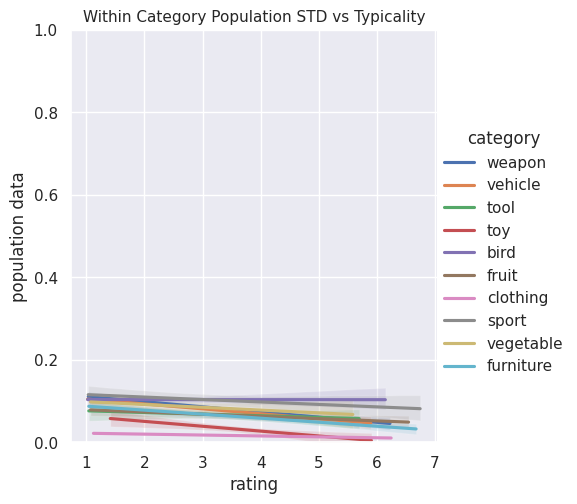

  Pearson correlation test using list-wise deletion
0                     Total observations used = 565
                population data    rank  rating   means
population data             1.0 -0.2211 -0.2993   0.731
rank                    -0.2211     1.0  0.9302 -0.2953
rating                  -0.2993  0.9302     1.0 -0.3878
means                     0.731 -0.2953 -0.3878     1.0
                population data    rank  rating   means
population data          0.0000  0.0000  0.0000  0.0000
rank                     0.0000  0.0000  0.0000  0.0000
rating                   0.0000  0.0000  0.0000  0.0000
means                    0.0000  0.0000  0.0000  0.0000


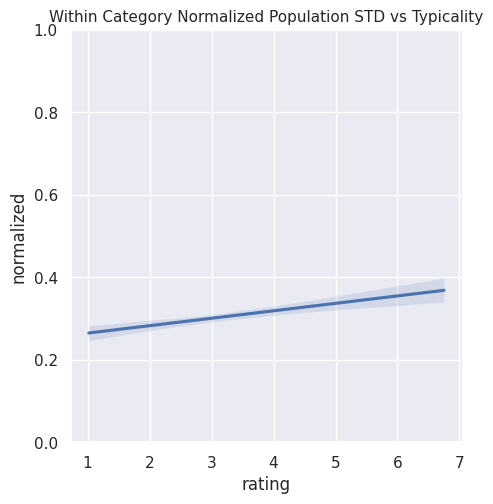

  Spearman Rank correlation test using list-wise deletion
0                      Total observations used = 565     
               normalized    rank  rating   means avg term freqs
normalized            1.0  0.1866  0.2587 -0.6135        -0.0334
rank               0.1866     1.0  0.9595 -0.2749         0.0084
rating             0.2587  0.9595     1.0 -0.3663         0.0194
means             -0.6135 -0.2749 -0.3663     1.0        -0.0685
avg term freqs    -0.0334  0.0084  0.0194 -0.0685            1.0
               normalized    rank  rating   means avg term freqs
normalized         0.0000  0.0000  0.0000  0.0000         0.4288
rank               0.0000  0.0000  0.0000  0.0000         0.8420
rating             0.0000  0.0000  0.0000  0.0000         0.6449
means              0.0000  0.0000  0.0000  0.0000         0.1039
avg term freqs     0.4288  0.8420  0.6449  0.1039         0.0000


,item,category,normalized,rank,rating,means,avg term freqs
0,Atom bomb,weapon,0.264709,13.0,1.69,0.374455,0.0
1,Honda,vehicle,0.303691,12.0,2.03,0.265025,0.0
2,T-square,tool,0.575361,15.0,2.22,0.012936,0.0
3,airplane,toy,0.249105,46.0,3.66,0.100697,20699.0
4,airplane,vehicle,0.317788,18.0,2.64,0.310555,20699.0
...,...,...,...,...,...,...,...
560,wrench,tool,0.217416,23.0,2.60,0.486819,6021.0
561,wrestling,sport,0.096290,20.0,1.87,0.870411,122769.0
562,yacht,vehicle,0.317352,30.0,3.76,0.155366,25959.0
563,yam,vegetable,0.270473,39.0,3.31,0.182756,4122.0


In [10]:


std = corr_df.groupby(['item','category']).aggregate({'population data':np.std})
std['rank'] = corr_df.groupby(['item','category'])['rank'].first()
std['rating'] = corr_df.groupby(['item','category'])['rating'].first()
std['means'] = corr_df.groupby(['item','category'])['population data'].mean()
std = std.reset_index()

# need to verify that the rank and rating are correctly matched to the item/category

sns.lmplot(x='rating', y="population data", data=std, scatter=False, hue ='category')
plt.ylim(0, 1.0)
plt.title( "Within Category Population STD vs Typicality" , size = 11 )
plt.show()


i,r,p = rp.correlation.corr_case(std, method = test)
print(i)
print(r)
print(p)



std = corr_df.groupby(['item','category']).aggregate({'normalized':np.std})
std['rank'] = corr_df.groupby(['item','category'])['rank'].first()
std['rating'] = corr_df.groupby(['item','category'])['rating'].first()
std['means'] = corr_df.groupby(['item','category'])['population data'].mean()


if model in models[0:2]:
  std['avg term freqs'] = corr_df.groupby(['item','category'])['term freqs'].first()
std = std.reset_index()

# need to verify that the rank and rating are correctly matched to the item/category

temp = std[std['category']=='weapon'].copy()
temp = std.copy()

cats = ['bird', 'tool', 'fruit', 'vegetable', 'clothing']
cat = cats[0]
sns.lmplot(x='rating', y="normalized", data=temp, scatter=False)
plt.ylim(0, 1.0)
plt.title( "Within Category Normalized Population STD vs Typicality" , size = 11 )
plt.show()

#print('-------------')
test = 'spearman'

i,r,p = rp.correlation.corr_case(temp, method = test)
print(i)
print(r)
print(p)

std

For roberta, surprisingly the std of the probabilities in the population has a negative correlation with the typicality. However, when the probabilities are min max normalized to all be between 0 and 1, the correlation goes away.

This suggests that the standard deviation of the probability may itself be a function of the magnitude of the probability. Thus, for roberta, there is no correlation between std and typicality.

However, for GPT-2 Large there is a strong negative correlation between the std of the min max normalized score and the typicality (r = -0.33 , p = 0.01) for the category 'bird'. Again, this suggests that the model becomes more certain as objects become less typical.

It also seems that ['bird', 'tool', 'fruit', 'vegetable', 'clothing'], are consistently the categories which have typicality least correlated with their probabilities.

For mean normalization roberta has strong corellation in the category weapon with the std of the mean normalized probs. Moreover, the total spearman corellation of the std of the normalized probability with typicality is positive and statistically significant with a r = 0.16. Thus, the correlation is small. But, this clearly shows that, for roberta, mean normalization conforms to intuition that model uncertainty will grow as the typicality decreases.

bert-large-uncased
--------------
toy
                normalized      rank    rating     means  avg term freqs
normalized        1.000000  0.111142  0.111542 -0.308363       -0.258703
rank              0.111142  1.000000  0.999903 -0.283579        0.326921
rating            0.111542  0.999903  1.000000 -0.282411        0.326981
means            -0.308363 -0.283579 -0.282411  1.000000       -0.359350
avg term freqs   -0.258703  0.326921  0.326981 -0.359350        1.000000
            rating normalized
rating      0.0000     0.3962
normalized  0.3962     0.0000
--------------
clothing
                normalized      rank    rating     means  avg term freqs
normalized        1.000000 -0.006421 -0.006747 -0.548341        0.207497
rank             -0.006421  1.000000  0.999928 -0.377778       -0.075329
rating           -0.006747  0.999928  1.000000 -0.378743       -0.075876
means            -0.548341 -0.377778 -0.378743  1.000000       -0.141557
avg term freqs    0.207497 -0.075329 -0.07587

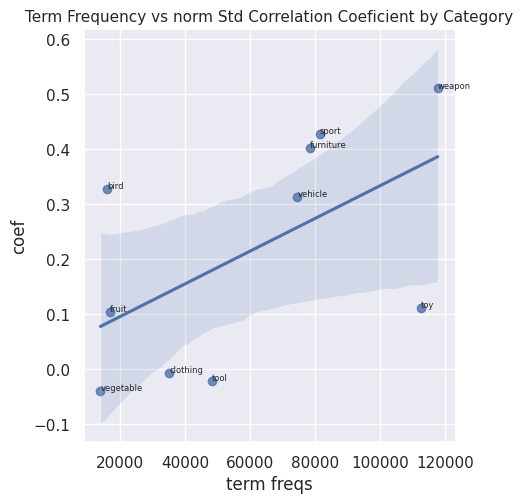

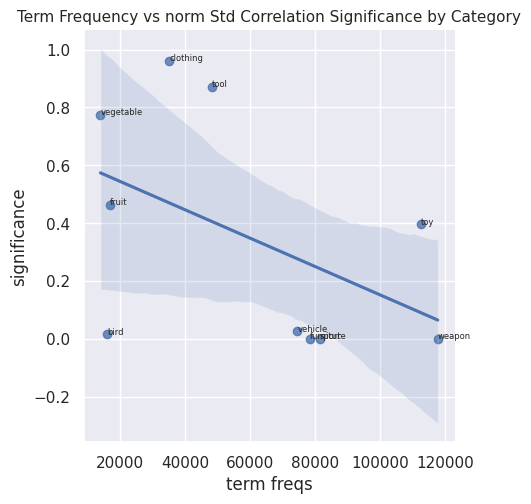

(  Spearman Rank correlation test using list-wise deletion
0                       Total observations used = 10     ,            term freqs    coef
term freqs        1.0  0.6727
coef           0.6727     1.0,            term freqs    coef
term freqs     0.0000  0.0330
coef           0.0330  0.0000)
(  Spearman Rank correlation test using list-wise deletion
0                       Total observations used = 10     ,              term freqs significance
term freqs          1.0         -0.6
significance       -0.6          1.0,              term freqs significance
term freqs       0.0000       0.0667
significance     0.0667       0.0000)


In [11]:
# This experiment only works for Bert


#rosch_val = 'rank'
rosch_val = 'rating'

categories = ['toy', 'clothing', 'sport', 'bird', 'tool', 'vegetable', 'vehicle', 'weapon', 'fruit', 'furniture']

print(model)

corrs = []
sigs = []
cat_freqs = []

for category in categories:

  temp = std.copy()[std['category']==category]
  print('--------------')
  print(category)
  print(temp.corr(method=test))

  i,r,p = rp.correlation.corr_case(temp[[rosch_val, 'normalized']], method = test)
  # print(i)
  # print(r)
  print(p)
  if model in models[0:2]:
    sigs.append(p[rosch_val][1])
    corrs.append(r[rosch_val][1])
    cat_freqs.append(np.mean(temp['avg term freqs']))


# check to see if the correlation with in categories of the normalized std is correlated with term frequency or category frequency in training

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']),size=6)

if model in models[0:2]:
  df = pd.DataFrame(list(zip(categories, corrs, sigs, cat_freqs)),
                columns =['category', 'coef', 'significance', 'term freqs'])

  df['significance'] = df['significance'].astype('float')

  sns.lmplot(x='term freqs', y="coef", data=df, scatter=True)
  plt.title( "Term Frequency vs norm Std Correlation Coeficient by Category" , size = 11 )
  label_point(df['term freqs'], df['coef'], df['category'], plt.gca())
  plt.show()


  sns.lmplot(x='term freqs', y="significance", data=df, scatter=True)
  plt.title( "Term Frequency vs norm Std Correlation Significance by Category", size = 11 )
  label_point(df['term freqs'], df['significance'], df['category'], plt.gca())
  plt.show()

  print(rp.correlation.corr_case(df[['term freqs', "coef"]], method = test))
  print(rp.correlation.corr_case(df[['term freqs', "significance"]], method = test))

  df

For bert large, fruit vegetable tool clothing and toy are the categories that the std suggests are not well understood by the model. Fruit vegetable tool and clothing are also among the categories with the lower avg term freqs. So, the idea that category understanding is captured in correlation significance of the norm prob std and the typicality is accurate.

There's good reason to believe that if dropout were turned up to 0.5 we would see that norm std of the prob pattern is also then in the prob correlation with typicality (as is shown to be the case for GPT-2).

The exceptions are bird and toy. Bird is well understood by the model (as judged by the significance of the std norm prob correlation with typicality) even though the term frequencies for it are quite low. Toy is not well understood even though the items have been seen.

For toy, this makes sense as many of the things considered toys in the Rosch study are not often spoken of as toys now. ie. marbles, clay, football.

In [ ]:
# Do randomly selected groups of models tend to agree with each other's rankings?
# The point to be made here is that performing an internal consistency check as is common within a group
# in psychology is not a valid technique in artificial populations.



In [ ]:
# Do GPT variants and Bert variants tend to agree with each other in the base model?
# The point to be made here is that across differing types of models, there is not consistency as one would expect
# in human groups in psychological studies. This suggests that the models are not members of the same species/culture.



In [10]:
# Does glass's delta of the population function as a summart statistic that captures the fact that some of the models
# are outliers among the population?

import numpy as np
from scipy.stats import ttest_ind, ttest_ind_from_stats, combine_pvalues
from scipy.special import stdtr

from statsmodels.stats.power import TTestPower, TTestIndPower

print('glass delta on probs')
d = (np.mean(corr_df['population data'])-np.mean(corr_misra['population data']))/np.std(corr_df['population data'])
print(d)

# print('glass delta on probs looking at individual items')
this = ((corr_df.groupby(['item','category'])['population data'].mean() -
 corr_misra.groupby(['item', 'category'])['population data'].mean())/
 corr_df.groupby(['item','category'])['population data'].std())
# print(this.mean())

print(ttest_ind(corr_df['population data'], corr_misra['population data'], equal_var=False))


# factors for power analysis
alpha = 0.05
power = 0.8

# perform power analysis to find sample size
# for given effect
power = TTestPower()
n_test = power.solve_power(nobs=corr_df.shape[0]+corr_misra.shape[0], effect_size = d,
                           power = None, alpha = 0.01/50)
print('Power: {:.3f}'.format(n_test))

glass delta on probs
0.18017771919212383
Ttest_indResult(statistic=5.622244138090126, pvalue=2.880841762498702e-08)
Power: 1.000


GPT2


glass delta on probs
0.05832357410861119
glass delta on probs looking at individual items
0.18445337217796248
Ttest_indResult(statistic=1.5589439949118977, pvalue=0.11954256105185565)
Ttest_indResult(statistic=7.4469845760242395, pvalue=3.108894458961362e-13)


GPT2 Medium


glass delta on probs
-0.09212967454514355
glass delta on probs looking at individual items
-0.19963847746923716
Ttest_indResult(statistic=-2.0863238796808656, pvalue=0.03738178843159454)
Ttest_indResult(statistic=-6.483489752269124, pvalue=1.8464682062496194e-10)


Roberta base


glass delta on probs
-0.10906326895057913
glass delta on probs looking at individual items
-0.14870056363037937
Ttest_indResult(statistic=-2.4240374637709805, pvalue=0.01565150654798966)
Ttest_indResult(statistic=-1.9496019221990613, pvalue=0.05166658265511888)


GPT - First population to move outside of the 95% confidence interval which is predicted by glass's delta on individual inferences


glass delta on probs
-0.11349848666609902
glass delta on probs looking at individual items
-0.25397201684288384
Ttest_indResult(statistic=-2.4865099426491812, pvalue=0.013178770720186491)
Ttest_indResult(statistic=-9.720761375051294, pvalue=6.090208315090304e-21)


Bert base


glass delta on probs
-0.12390693514657262
glass delta on probs looking at individual items
-0.24311008764849143
Ttest_indResult(statistic=-2.627248708991194, pvalue=0.008834560401270923)
Ttest_indResult(statistic=-3.7497449595929706, pvalue=0.00019363989732111081)


Distilbert


glass delta on probs
-0.1254520265604241
glass delta on probs looking at individual items
-0.3333446242193501
Ttest_indResult(statistic=-2.672209121554945, pvalue=0.007746293429805465)
Ttest_indResult(statistic=-7.555571690503777, pvalue=1.459955110701427e-13)


Bert Large


glass delta on probs
-0.13796673951071403
glass delta on probs looking at individual items
-0.291293897146821
Ttest_indResult(statistic=-2.970091502595978, pvalue=0.0030996393134000997)
Ttest_indResult(statistic=-6.728800195772663, pvalue=3.892409081437881e-11)


DistilGPT2


glass delta on probs
0.18017771919212383
glass delta on probs looking at individual items
0.4792574987916211
Ttest_indResult(statistic=5.622244138090126, pvalue=2.880841762498702e-08)
Ttest_indResult(statistic=27.861543154620716, pvalue=5.0680404648246805e-117)


Roberta Large


glass delta on probs
-0.32677724214310616
glass delta on probs looking at individual items
-0.47022191708987593
Ttest_indResult(statistic=-6.414246523492622, pvalue=2.9399464043025115e-10)
Ttest_indResult(statistic=-7.750186718458161, pvalue=4.0272115251936866e-14)



In [183]:
# loop through all models and calculate the per category correlation and significance with typicality
import plotly.graph_objects as go

results = {}
total_corr = {}
total_sig = {}

high_corr = {}
high_sig = {}


models = ['distilbert-base-uncased', 'bert-base-uncased', 'bert-large-uncased', 'roberta-base', 'roberta-large', 'openai-gpt', 'distilgpt2',
          'gpt2', 'gpt2-medium']

for model in models:

  misra_data_bert = pd.read_csv(loc+'rosch1975_alternate/'+model+".csv")
  df = pd.read_csv(loc+'rosch1975_alternate_popLM_50/'+model+".csv")
  rosch_ratings = pd.read_csv(loc+'rosch1975_ratings.csv')


  df['misra score (sum, mean, [list])'] = misra_data_bert['score (sum, mean, [list)'].apply(ast.literal_eval)
  df = pd.merge(df, rosch_ratings, on=['item', 'category'], how='left')

  df['score (sum, mean, [list)'] = df['score (sum, mean, [list)'].apply(ast.literal_eval)
  df.rename(columns={'score (sum, mean, [list)': 'popLM score (sum, mean, [list])'}, inplace=True)


  # for sum
  #select_reduction = 0
  # for mean
  select_reduction = 1

  df['population data'] = df.apply(
      lambda row: [2**t[select_reduction] for t in row['popLM score (sum, mean, [list])']],
      axis=1)
  df['misra_avg'] = df.apply(
      lambda row: 2**row['misra score (sum, mean, [list])'][select_reduction],
      axis=1)


  df['misra_avg'] = df['misra_avg'].astype('float')
  df['rating'] = df['rating'].astype('float')
  df['rank'] = df['rank'].astype('float')

  cols = ['population data', 'item', 'category', 'misra_avg', 'rating', 'rank']
  df = df[cols]

  df = df.explode('population data')
  df['member id'] = df.groupby(['item', 'category']).cumcount()+1
  df['population data'] = df['population data'].astype('float')
  df = df.drop(columns='misra_avg')

  #rosch_val = 'rank'
  rosch_val = 'rating'


  categories = ['weapon', 'vehicle', 'sport', 'furniture', 'toy', 'clothing', 'bird', 'fruit', 'tool', 'vegetable']

  corrs = []
  sigs = []
  cat_freqs = []

  df['normalized'] = df.groupby(['item','category'])['population data'].transform(lambda x: x/np.mean(x))
  test = 'pearson'

  for category in categories:
    temp = df.copy()[corr_df['category']==category]

    i,r,p = rp.correlation.corr_case(temp[[rosch_val, 'population data']], method = test)
    sigs.append(p[rosch_val][1])
    corrs.append(-1*r[rosch_val][1])

  results[model] = [corrs, sigs]

  i,r,p = rp.correlation.corr_case(df[[rosch_val, 'population data']], method = test)
  total_sig[model] = p[rosch_val][1]
  total_corr[model] = -1*r[rosch_val][1]

  i,r,p = rp.correlation.corr_case(df[df['category'].isin(categories[0:4])][[rosch_val, 'population data']], method = test)
  high_sig[model] = p[rosch_val][1]
  high_corr[model] = -1*r[rosch_val][1]

result = []
# categories.append('total')
for model in models:
#   results[model][0].append(total_corr[model])
#   results[model][1].append(total_sig[model])

  result.append(pd.DataFrame(list(zip(results[model][0], results[model][1], [model for category in categories], categories)),
                columns =['correlation', 'significance', 'model', 'category']))

result = pd.concat(result)

combined = pd.DataFrame(list(zip([total_corr[model] for model in models], [total_sig[model] for model in models],
                [model for model in models])),
                columns =['correlation', 'significance', 'model'])


high = pd.DataFrame(list(zip([high_corr[model] for model in models], [high_sig[model] for model in models],
                [model for model in models])),
                columns =['correlation', 'significance', 'model'])

result

,correlation,significance,model,category
0,0.5861,0.0000,distilbert-base-uncased,weapon
1,0.6979,0.0000,distilbert-base-uncased,vehicle
2,0.4493,0.0000,distilbert-base-uncased,sport
3,0.3822,0.0000,distilbert-base-uncased,furniture
4,0.3538,0.0000,distilbert-base-uncased,toy
...,...,...,...,...
5,0.4857,0.0000,gpt2-medium,clothing
6,-0.0820,0.0000,gpt2-medium,bird
7,0.1968,0.0000,gpt2-medium,fruit
8,0.0375,0.0398,gpt2-medium,tool


category                 weapon  vehicle   sport  furniture     toy  clothing  \
model                                                                           
distilbert-base-uncased  0.5861   0.6979  0.4493     0.3822  0.3538    0.4516   
bert-base-uncased        0.6252   0.5788  0.4866     0.3887  0.3613    0.3990   
bert-large-uncased       0.6441   0.5068  0.5194     0.4863  0.3510    0.3594   
roberta-base             0.5324   0.4644  0.4394     0.3623  0.2966    0.3693   
roberta-large            0.6285   0.5280  0.3881     0.4791  0.3036    0.3770   
openai-gpt               0.4967   0.5734  0.2422     0.5146  0.2548    0.4725   
distilgpt2               0.5100   0.5235  0.1896     0.2817  0.1610    0.2823   
gpt2                     0.4877   0.5687  0.1852     0.3222  0.1405    0.3831   
gpt2-medium              0.3988   0.5664  0.3685     0.4233  0.1239    0.4857   

category                   bird   fruit    tool  vegetable  
model                                          

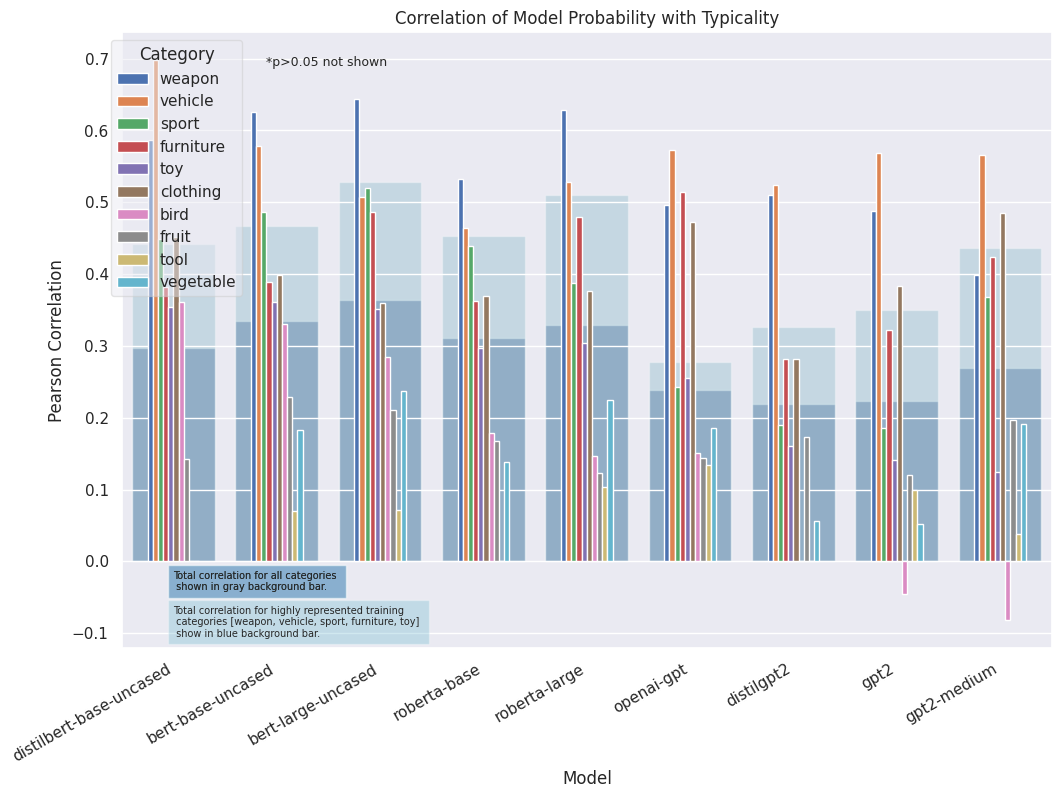

In [175]:
import matplotlib.ticker as mtick

result.category = result.category.astype("category")
result.category = result.category.cat.set_categories(categories)

result.model = result.model.astype("category")
result.model = result.model.cat.set_categories(models)

result.loc[result['significance'].astype('float')>0.05, "correlation"]= 0

grouped = result.groupby(['model', 'category'])['correlation'].sum().unstack()

print(grouped)

# # Create a stacked bar chart
# ax = grouped.plot(kind='bar', stacked=True, figsize=(12, 8))

# # Set the title and axis labels
# ax.set_title('Correlation of Model Probability with Typicality')
# ax.set_xlabel('Model')
# ax.set_ylabel('Correlation')

# handles, labels = ax.get_legend_handles_labels()
# ax.legend(reversed(handles), reversed(labels), title='Line', loc='upper left')

# # Rotate the x-axis labels for better visibility
# plt.xticks(rotation=45)

# # Show the plot
# plt.show()



# Create a bar chart
ax = grouped.plot(kind='bar', figsize=(12, 8))
sns.barplot(ax=ax, x=combined["model"], y=combined["correlation"], color='b', zorder=0, alpha=0.5)
sns.barplot(ax=ax, x=high["model"], y=high["correlation"], color='c', zorder=0, alpha=0.3)

# Set the title and axis labels
ax.set_title('Correlation of Model Probability with Typicality')
ax.set_xlabel('Model')
ax.set_ylabel('Pearson Correlation')

handles, labels = ax.get_legend_handles_labels()
#ax.legend(reversed(handles), reversed(labels), title='Line', loc='upper left', fancybox=True, framealpha=0.5)
ax.legend(title='Category', loc='upper left', fancybox=True, framealpha=0.5, bbox_to_anchor=(-0.02, 1))

ax.text(0.9, 0.69, '*p>0.05 not shown', fontsize=9)
ax.text(0, -0.04,
        'Total correlation for all categories \n shown in gray background bar.',
        fontsize=7).set_bbox(dict(facecolor='b', alpha=0.5))
ax.text(0, -0.04,
        'Total correlation for all categories \n shown in gray background bar.',
        fontsize=7).set_bbox(dict(facecolor='c', alpha=0.3))
ax.text(0, -0.105,
        'Total correlation for highly represented training \n categories [weapon, vehicle, sport, furniture, toy] \n show in blue background bar.',
        fontsize=7).set_bbox(dict(facecolor='c', alpha=0.3))
# Rotate the x-axis labels for better visibility
plt.xticks(rotation=30, ha="right")


# show the graph
plt.show()

In [221]:
# loop through all models and calculate the per category std correlation and significance with typicality
import plotly.graph_objects as go

results = {}
total_corr = {}
total_sig = {}

high_corr = {}
high_sig = {}


models = ['distilbert-base-uncased', 'bert-base-uncased', 'bert-large-uncased', 'roberta-base', 'roberta-large', 'openai-gpt', 'distilgpt2',
          'gpt2', 'gpt2-medium']

for model in models:

  misra_data_bert = pd.read_csv(loc+'rosch1975_alternate/'+model+".csv")
  df = pd.read_csv(loc+'rosch1975_alternate_popLM_50/'+model+".csv")
  rosch_ratings = pd.read_csv(loc+'rosch1975_ratings.csv')


  df['misra score (sum, mean, [list])'] = misra_data_bert['score (sum, mean, [list)'].apply(ast.literal_eval)
  df = pd.merge(df, rosch_ratings, on=['item', 'category'], how='left')

  df['score (sum, mean, [list)'] = df['score (sum, mean, [list)'].apply(ast.literal_eval)
  df.rename(columns={'score (sum, mean, [list)': 'popLM score (sum, mean, [list])'}, inplace=True)


  # for sum
  #select_reduction = 0
  # for mean
  select_reduction = 1

  df['population data'] = df.apply(
      lambda row: [2**t[select_reduction] for t in row['popLM score (sum, mean, [list])']],
      axis=1)
  df['misra_avg'] = df.apply(
      lambda row: 2**row['misra score (sum, mean, [list])'][select_reduction],
      axis=1)


  df['misra_avg'] = df['misra_avg'].astype('float')
  df['rating'] = df['rating'].astype('float')
  df['rank'] = df['rank'].astype('float')

  cols = ['population data', 'item', 'category', 'misra_avg', 'rating', 'rank']
  df = df[cols]

  df = df.explode('population data')
  df['member id'] = df.groupby(['item', 'category']).cumcount()+1
  df['population data'] = df['population data'].astype('float')
  df = df.drop(columns='misra_avg')

  df['population data'] = df.groupby(['item','category'])['population data'].transform(lambda x: x/np.mean(x))

  std = df.groupby(['item','category']).aggregate({'population data':np.std})
  std['rank'] = corr_df.groupby(['item','category'])['rank'].first()
  std['rating'] = corr_df.groupby(['item','category'])['rating'].first()
  std['means'] = corr_df.groupby(['item','category'])['population data'].mean()
  std = std.reset_index()

  #rosch_val = 'rank'
  rosch_val = 'rating'


  categories = ['weapon', 'vehicle', 'sport', 'furniture', 'toy', 'clothing', 'bird', 'fruit', 'tool', 'vegetable']

  corrs = []
  sigs = []
  cat_freqs = []

  test = 'spearman'

  for category in categories:
    temp = std.copy()[std['category']==category]

    i,r,p = rp.correlation.corr_case(temp[[rosch_val, 'population data']], method = test)
    sigs.append(p[rosch_val][1])
    corrs.append(r[rosch_val][1])

  results[model] = [corrs, sigs]

  i,r,p = rp.correlation.corr_case(std[[rosch_val, 'population data']], method = test)
  total_sig[model] = p[rosch_val][1]
  total_corr[model] = r[rosch_val][1]

  i,r,p = rp.correlation.corr_case(std[std['category'].isin(categories[0:4])][[rosch_val, 'population data']], method = test)
  high_sig[model] = p[rosch_val][1]
  high_corr[model] = r[rosch_val][1]

result = []
# categories.append('total')
for model in models:
#   results[model][0].append(total_corr[model])
#   results[model][1].append(total_sig[model])

  result.append(pd.DataFrame(list(zip(results[model][0], results[model][1], [model for category in categories], categories)),
                columns =['correlation', 'significance', 'model', 'category']))

result = pd.concat(result)

combined = pd.DataFrame(list(zip([total_corr[model] for model in models], [total_sig[model] for model in models],
                [model for model in models])),
                columns =['correlation', 'significance', 'model'])


high = pd.DataFrame(list(zip([high_corr[model] for model in models], [high_sig[model] for model in models],
                [model for model in models])),
                columns =['correlation', 'significance', 'model'])

result




,correlation,significance,model,category
0,0.3896,0.0021,distilbert-base-uncased,weapon
1,0.3830,0.0060,distilbert-base-uncased,vehicle
2,0.5216,0.0000,distilbert-base-uncased,sport
3,0.2677,0.0386,distilbert-base-uncased,furniture
4,0.2272,0.0809,distilbert-base-uncased,toy
...,...,...,...,...
5,-0.1842,0.1781,gpt2-medium,clothing
6,-0.2720,0.0466,gpt2-medium,bird
7,-0.0224,0.8758,gpt2-medium,fruit
8,-0.0247,0.8515,gpt2-medium,tool


category                 weapon  vehicle   sport  furniture     toy  clothing  \
model                                                                           
distilbert-base-uncased  0.3896   0.3830  0.5216     0.2677  0.2272    0.2383   
bert-base-uncased        0.4908   0.5030  0.5328     0.2554  0.0000    0.0000   
bert-large-uncased       0.5130   0.3180  0.4310     0.4043  0.0000    0.0000   
roberta-base             0.3988   0.0000  0.3616     0.0000  0.2586    0.4346   
roberta-large            0.5706   0.4743  0.2849     0.2444  0.0000    0.0000   
openai-gpt               0.0000   0.0000 -0.2942     0.0000  0.0000   -0.3115   
distilgpt2              -0.2318   0.0000 -0.3673     0.0000 -0.2647    0.0000   
gpt2                    -0.3374   0.0000 -0.3421     0.0000 -0.2975    0.0000   
gpt2-medium             -0.3454   0.0000  0.0000     0.0000 -0.2667    0.0000   

category                   bird   fruit    tool  vegetable  
model                                          

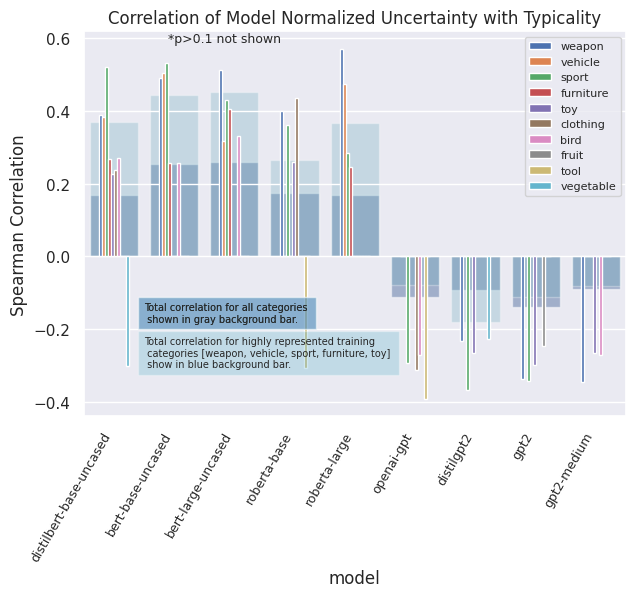

In [246]:
import matplotlib.ticker as mtick

result.category = result.category.astype("category")
result.category = result.category.cat.set_categories(categories)

result.model = result.model.astype("category")
result.model = result.model.cat.set_categories(models)

result.loc[result['significance'].astype('float')>0.1, "correlation"]= 0

grouped = result.groupby(['model', 'category'])['correlation'].sum().unstack()

print(grouped)

# # Create a stacked bar chart
# ax = grouped.plot(kind='bar', stacked=True, figsize=(12, 8))

# # Set the title and axis labels
# ax.set_title('Correlation of Model Probability with Typicality')
# ax.set_xlabel('Model')
# ax.set_ylabel('Correlation')

# handles, labels = ax.get_legend_handles_labels()
# ax.legend(reversed(handles), reversed(labels), title='Line', loc='upper left')

# # Rotate the x-axis labels for better visibility
# plt.xticks(rotation=45)

# # Show the plot
# plt.show()



# Create a bar chart
ax = grouped.plot(kind='bar', figsize=(7, 5))
sns.barplot(ax=ax, x=combined["model"], y=combined["correlation"], color='b', zorder=0, alpha=0.5)
sns.barplot(ax=ax, x=high["model"], y=high["correlation"], color='c', zorder=0, alpha=0.3)

# Set the title and axis labels
ax.set_title('Correlation of Model Normalized Uncertainty with Typicality', fontsize=12)
ax.set_ylabel('Spearman Correlation', fontsize=12)

handles, labels = ax.get_legend_handles_labels()
#ax.legend(reversed(handles), reversed(labels), title='Line', loc='upper left', fancybox=True, framealpha=0.5)
ax.legend(title='Category', loc='upper right', fancybox=True, framealpha=0.5)

ax.text(0.9, 0.59, '*p>0.1 not shown', fontsize=9)
ax.text(0.5, -0.18,
        'Total correlation for all categories \n shown in gray background bar.',
        fontsize=7).set_bbox(dict(facecolor='b', alpha=0.5))
ax.text(0.5, -0.18,
        'Total correlation for all categories \n shown in gray background bar.',
        fontsize=7).set_bbox(dict(facecolor='c', alpha=0.3))
ax.text(0.5, -0.305,
        'Total correlation for highly represented training \n categories [weapon, vehicle, sport, furniture, toy] \n show in blue background bar.',
        fontsize=7).set_bbox(dict(facecolor='c', alpha=0.3))
# Rotate the x-axis labels for better visibility
plt.xticks(rotation=60, ha="right", fontsize=9)
plt.legend(prop={'size': 8})

# show the graph
plt.show()